In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from scipy.special import inv_boxcox

In [ ]:
df = pd.read_csv('/content/car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [ ]:
df.shape

(301, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [ ]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [ ]:
df.duplicated().sum()

2

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(299, 9)

In [ ]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,299.000000,299.000000,299.000000,299.000000,299.000000
mean,2013.615385,4.589632,7.541037,36916.752508,0.043478
std,2.896868,4.984240,8.567887,39015.170352,0.248720
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.850000,1.200000,15000.000000,0.000000
50%,2014.000000,3.510000,6.100000,32000.000000,0.000000
75%,2016.000000,6.000000,9.840000,48883.500000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [ ]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,299,299,299,299
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,193,260


Data Preparation

In [ ]:
df['Car_Name'].nunique()

98

In [ ]:
df.drop('Car_Name', axis=1, inplace=True)

In [ ]:
df['Age'] = df['Year'].max() +1 - df['Year']
df.drop('Year', axis = 1, inplace = True)
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,2
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,8
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,5


Outlier Detection

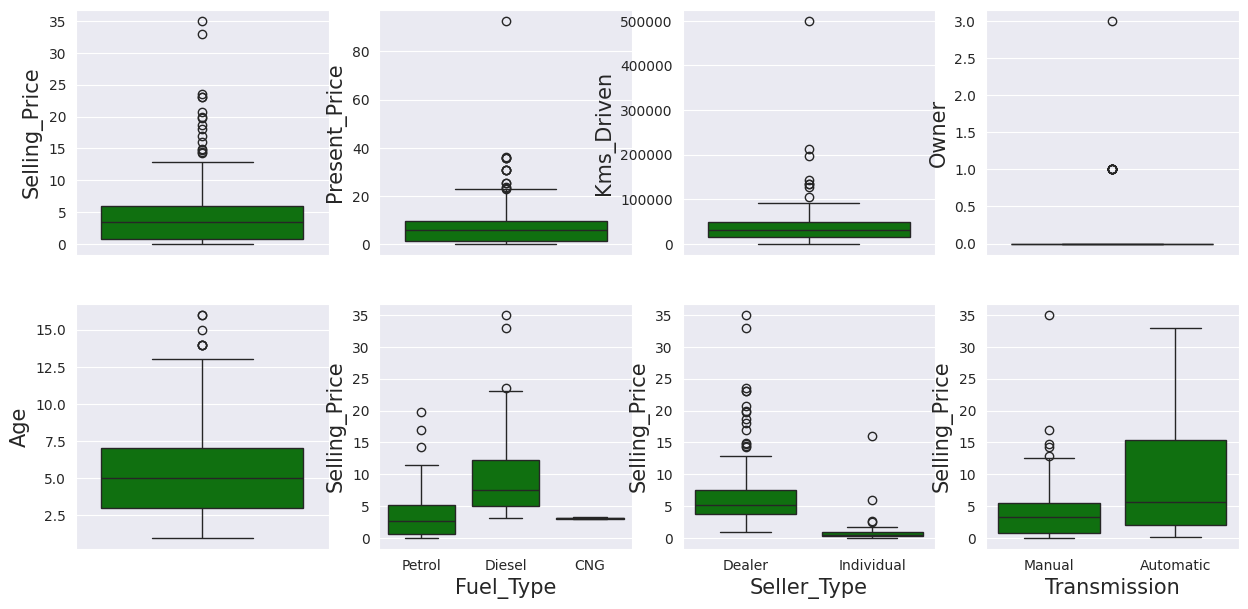

In [ ]:
sns.set_style('darkgrid')
colors = ['green', 'blue', 'orange']
CustomPalette = sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,7), dpi=100)

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,
                              df.select_dtypes(include='object').columns.values])

for i, col in enumerate(OrderedCols):
  x = i // 4
  y = i % 4
  if i<5:
      sns.boxplot(data=df, y = col, ax = ax[x,y])
      ax[x,y].yaxis.label.set_size(15)
  else:
      sns.boxplot(data=df, x = col, y = 'Selling_Price', ax = ax[x,y])
      ax[x,y].xaxis.label.set_size(15)
      ax[x,y].yaxis.label.set_size(15)


plt.show()

In [ ]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())


for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

39 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 78, 79, 80, 205, 82, 84, 85, 86, 92, 96, 97, 106, 241, 250]


 Outliers Labeling

In [ ]:
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

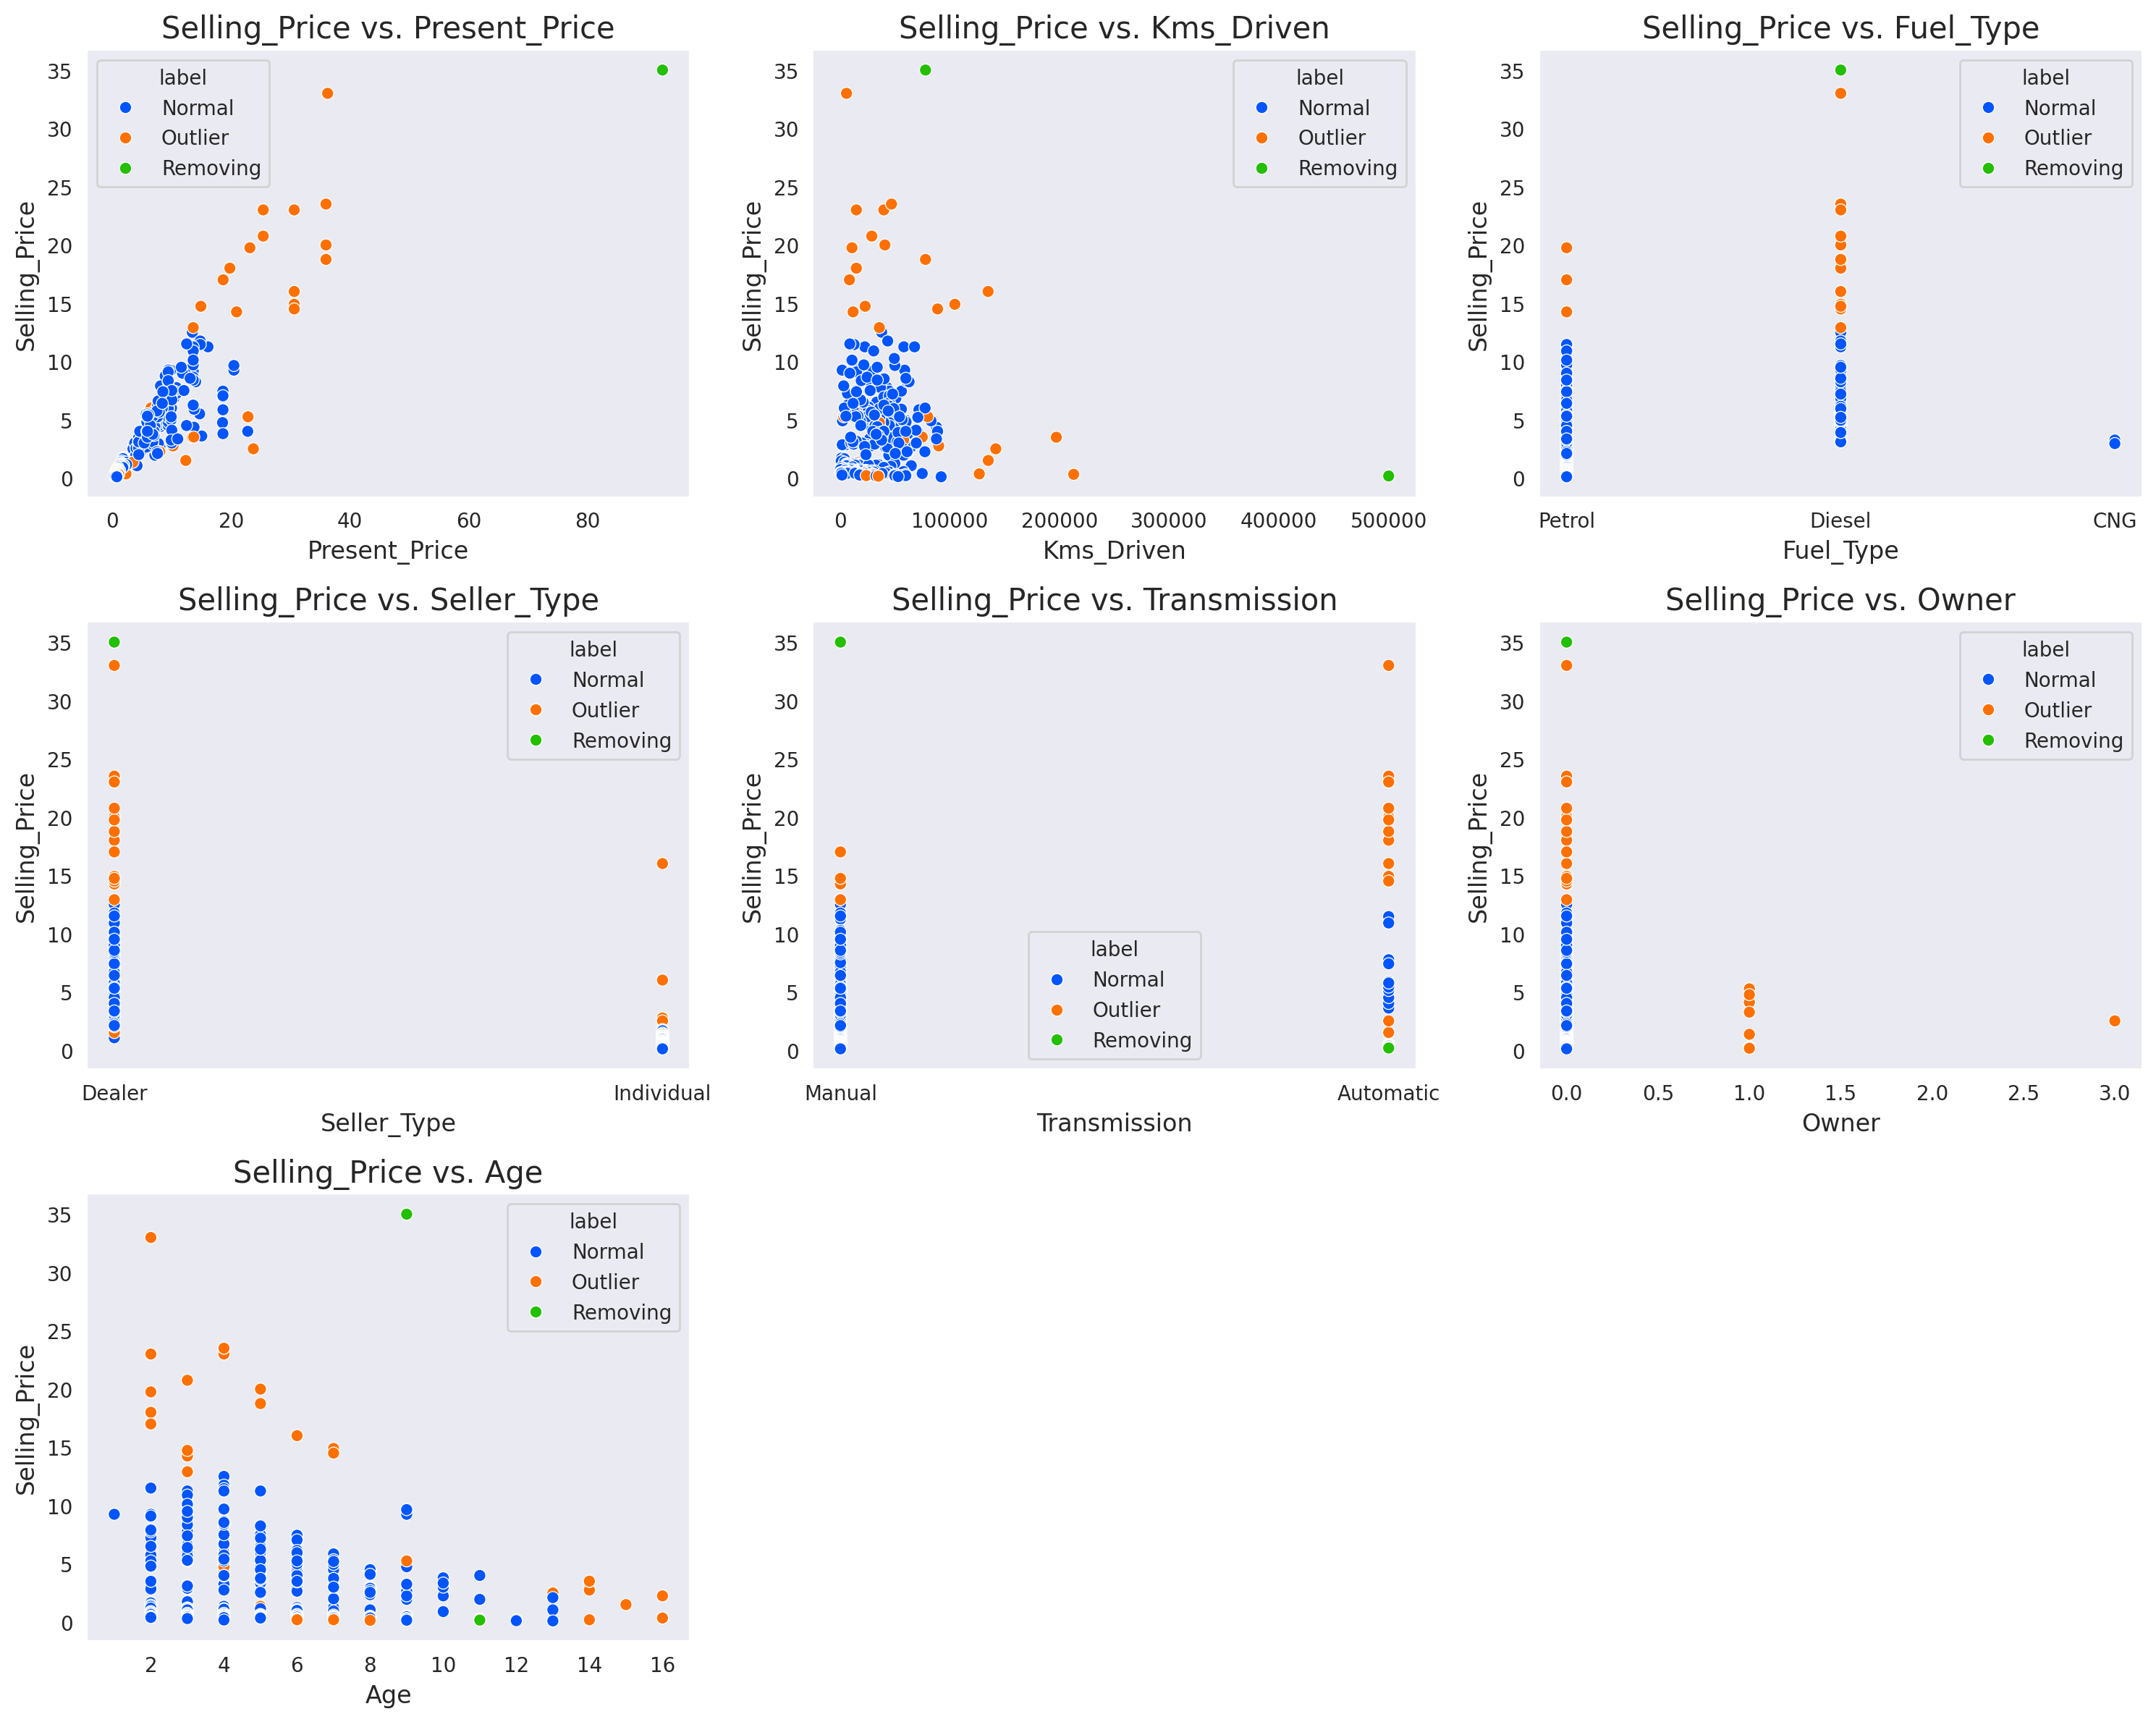

In [ ]:
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [ ]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

EDA : Categorical Variables Univariate Analysis

<ipython-input-164-a4d3985eb1f0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
<ipython-input-164-a4d3985eb1f0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
<ipython-input-164-a4d3985eb1f0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)


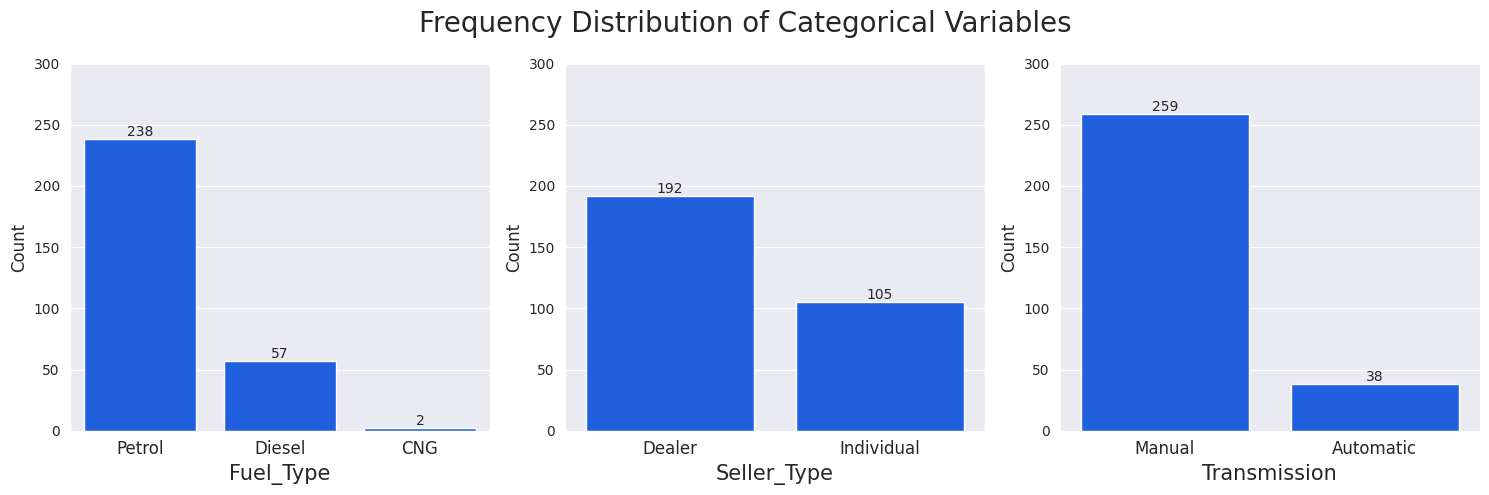

In [ ]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20)
plt.tight_layout()
plt.show()

EDA : Numerical Variables Univariate Analysis

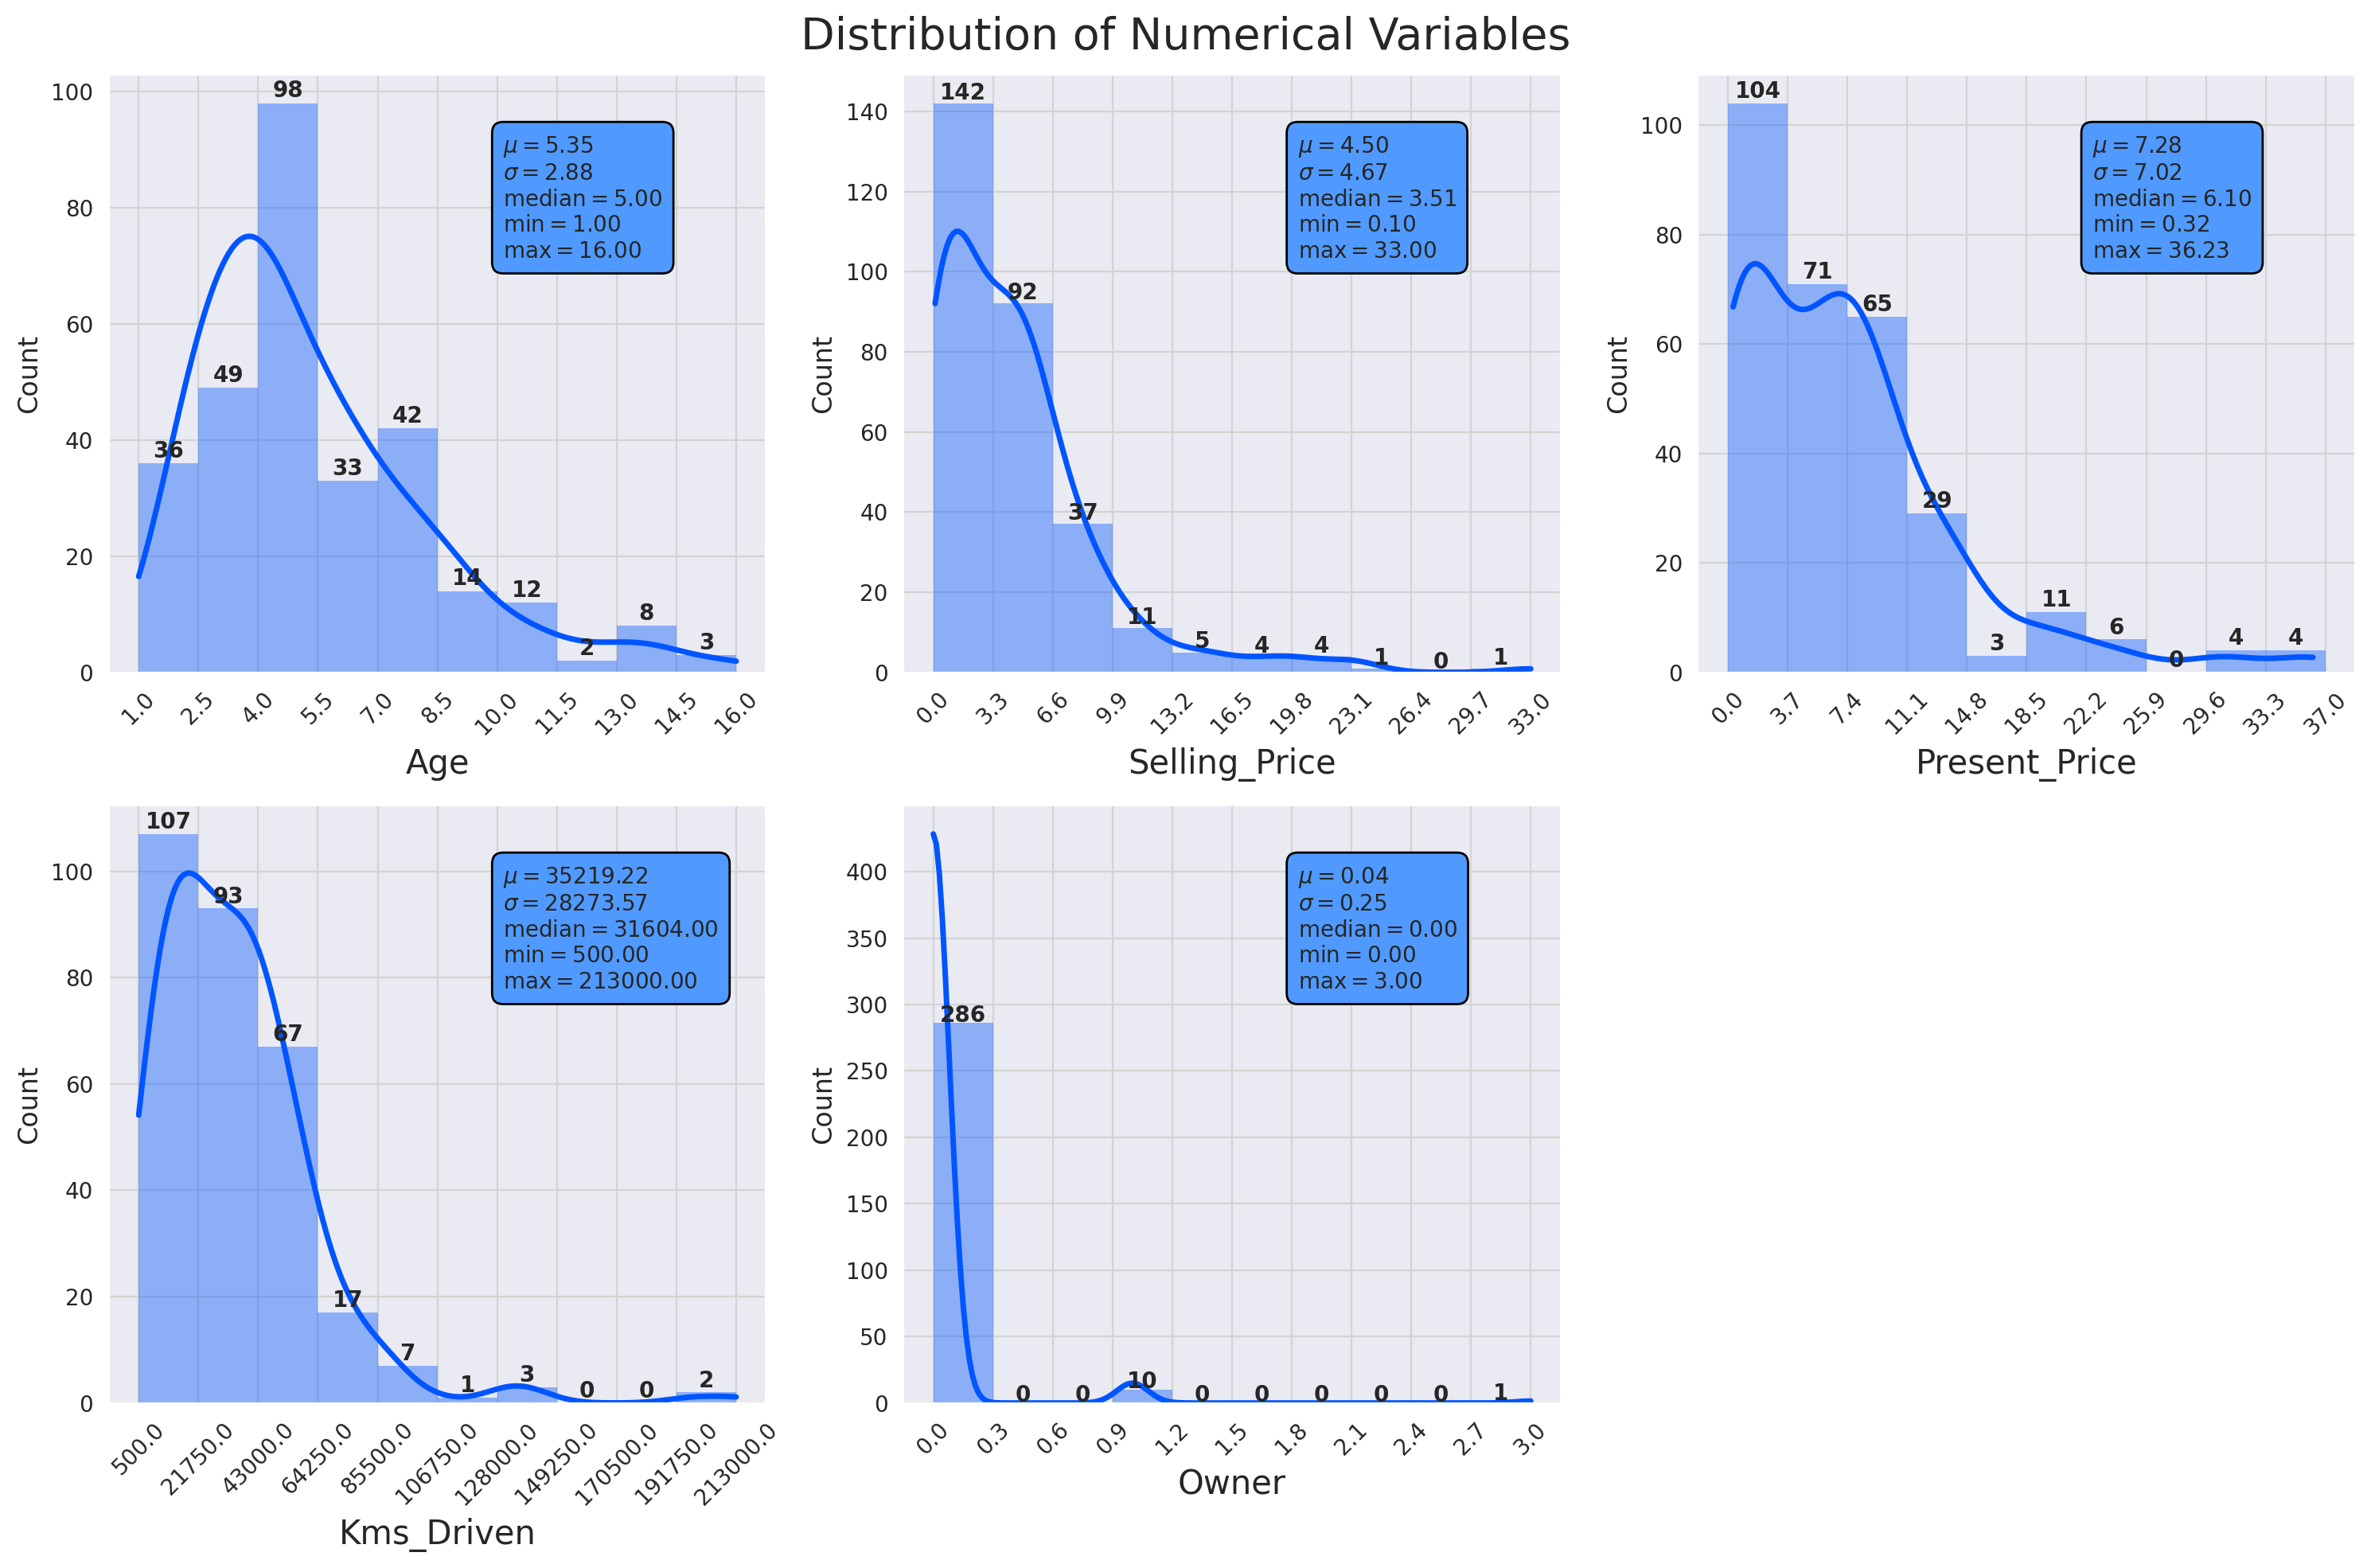

In [ ]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]],
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")

    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.show()


Target vs. Numerical Features Bivariate Analysis

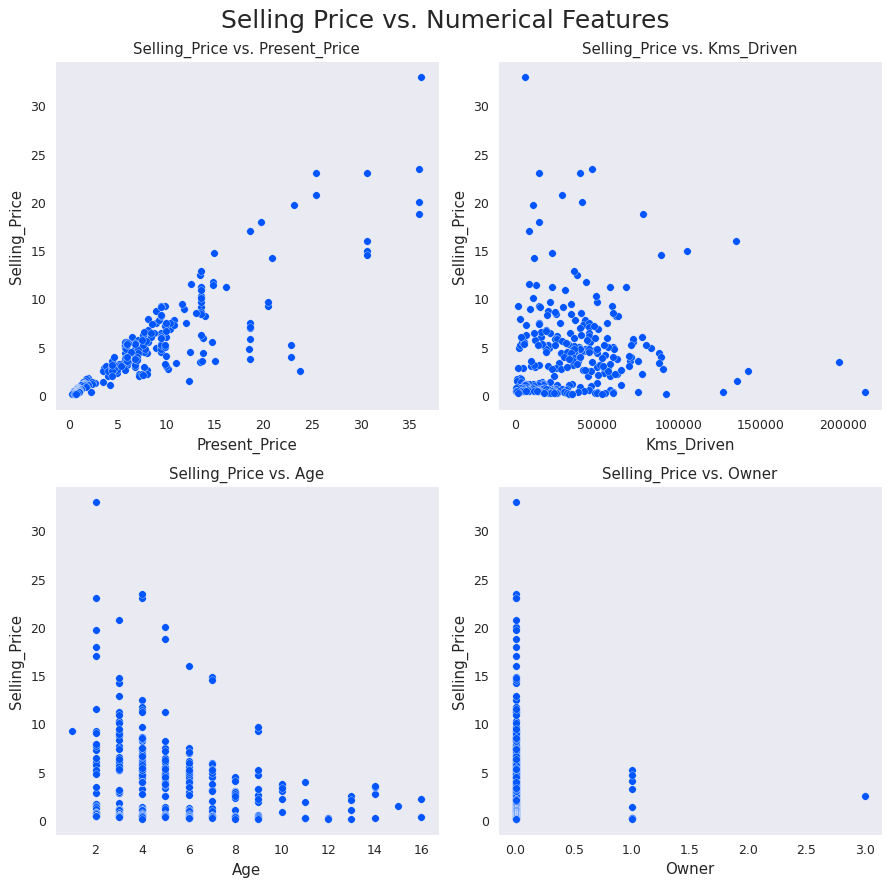

In [ ]:
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(10,10), dpi=90)
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color=c, edgecolors='w', linewidths=0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size = 12)
    ax[row,col].set_xlabel(num_features[i], size = 12)
    ax[row,col].set_ylabel(target, size = 12)
    ax[row,col].grid()

plt.suptitle('Selling Price vs. Numerical Features', size = 20)
plt.tight_layout()
plt.show()

Target vs. Categorical Features Bivariate Analysis

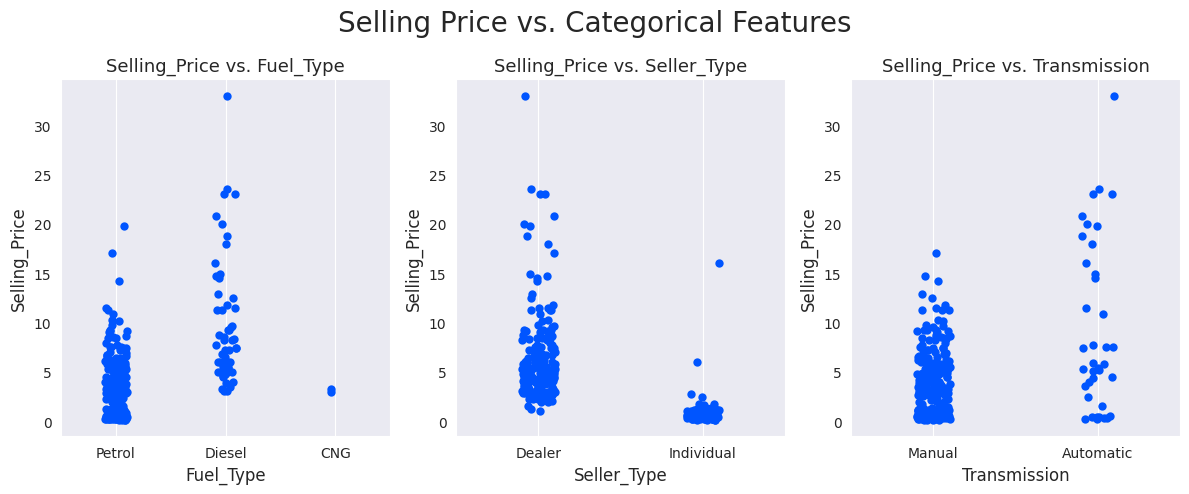

In [ ]:
fig, axes = plt.subplots(nrows=1 ,ncols=3, figsize=(12,5), dpi=100)
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()

Multivariate Analysis

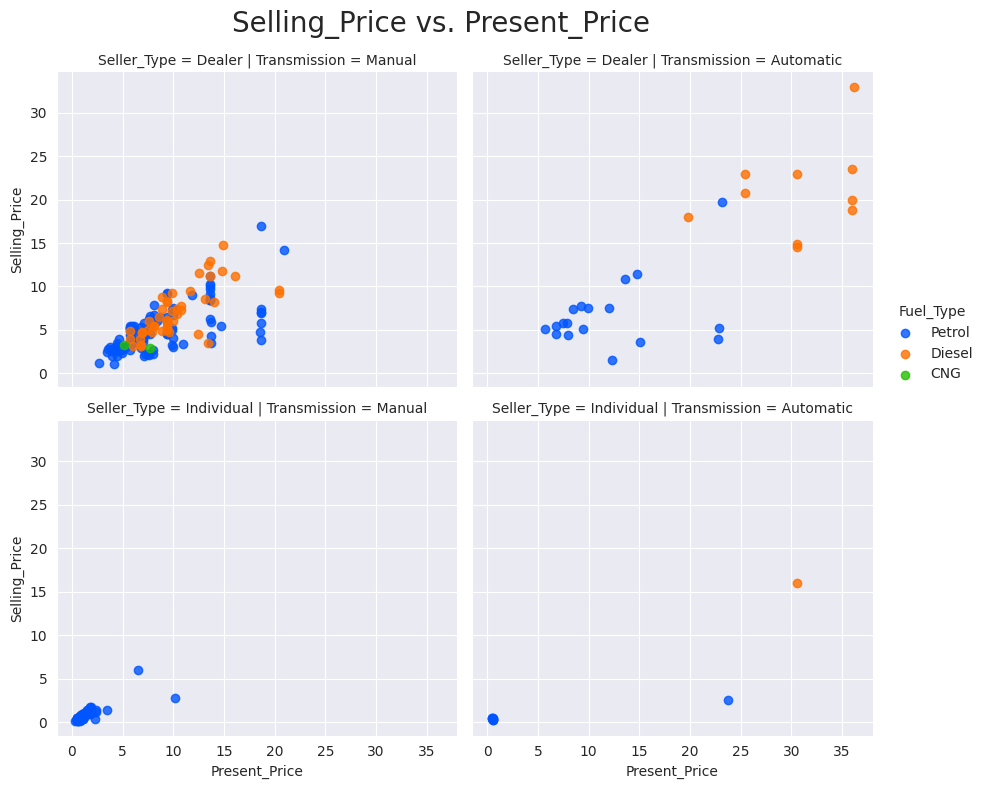

In [ ]:
graph = sns.lmplot(x='Present_Price', y='Selling_Price', data= df1, fit_reg=False, row='Seller_Type',
                   col='Transmission', hue='Fuel_Type', palette=CustomPalette, height=4, aspect=1)

plt.suptitle('Selling_Price vs. Present_Price', fontsize=20)
sns.move_legend(graph, "lower center", bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

Categorical Variables Encoding

In [ ]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Selling_Price,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,5,False,True,False,True
1,4.75,9.54,43000,0,6,True,False,False,True
2,7.25,9.85,6900,0,2,False,True,False,True
3,2.85,4.15,5200,0,8,False,True,False,True
4,4.60,6.87,42450,0,5,True,False,False,True


## Correlation Analysis

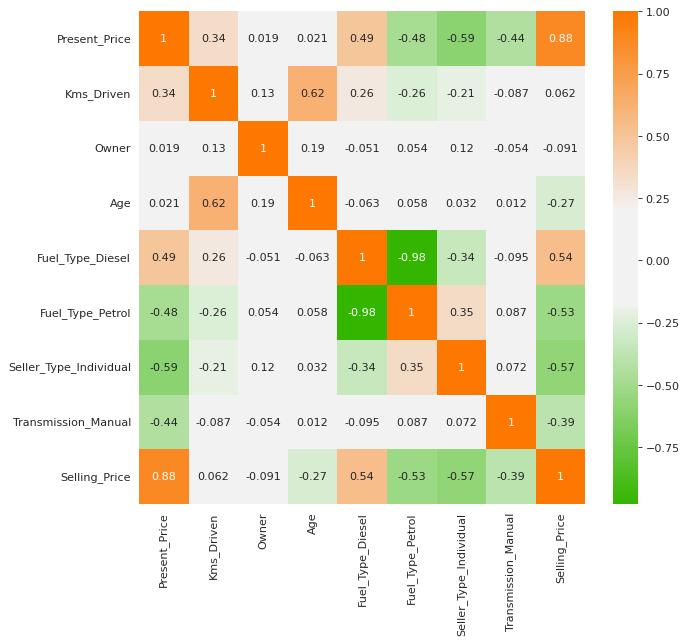

In [ ]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

## Build Linear Regression Model

In [ ]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (207, 8)
X_test shape:  (90, 8)
y_train shape:  (207,)
y_test shape:  (90,)


In [ ]:
y_test_actual = y_test

Scale Data using Standard Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train the Model

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_),
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.336570
Present_Price Coef.,3.683557
Fuel_Type_Diesel Coef.,0.806576
Fuel_Type_Petrol Coef.,0.207959
Transmission_Manual Coef.,-0.085335
Owner Coef.,-0.240508
Seller_Type_Individual Coef.,-0.392281
Kms_Driven Coef.,-0.564721
Age Coef.,-0.871912


Model Evaluation

In [ ]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)

    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [ ]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,1.014296
MSE,2.828876
RMSE,1.681926
R2-Score,0.880799


Model Evaluation using Cross-Validation

In [ ]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0)
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.129362,0.199263
MSE,3.045037,1.105924
RMSE,1.715227,0.320987
R2-Score,0.841662,0.040340


In [ ]:
del df1['Fuel_Type_Petrol']

In [ ]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

In [ ]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

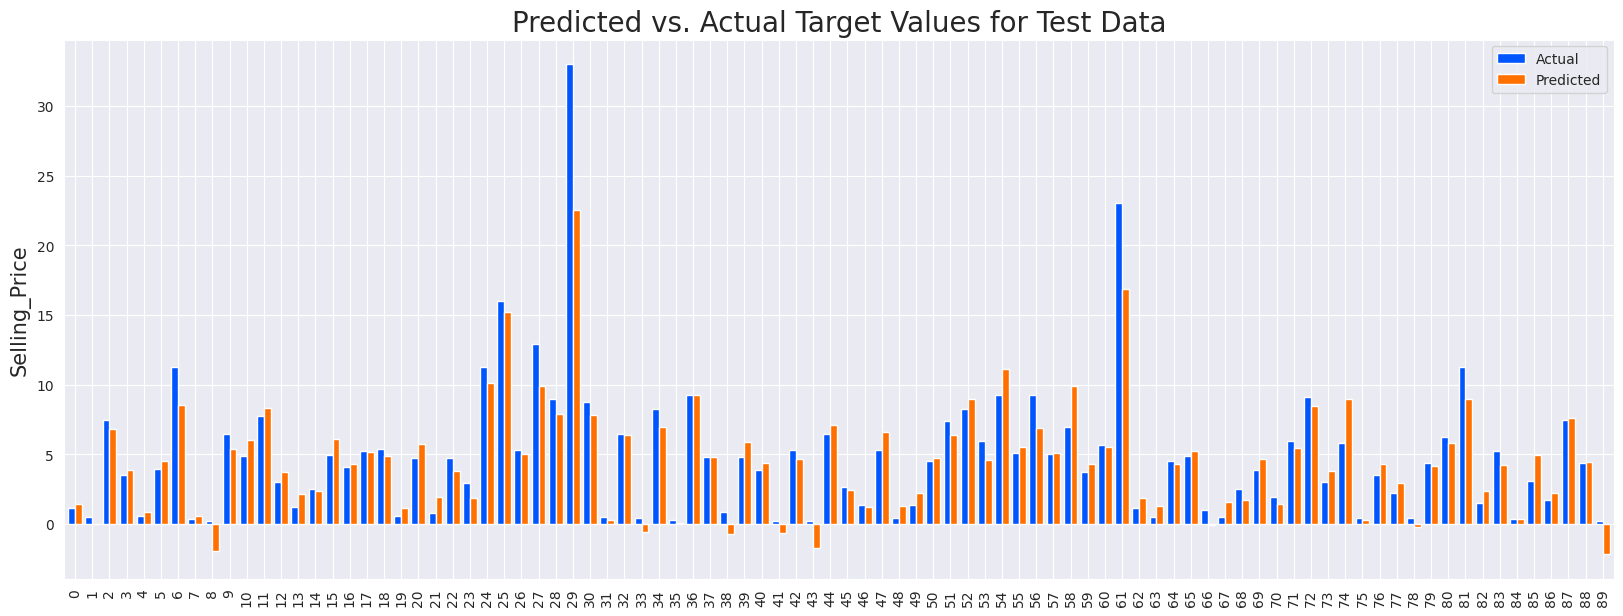

In [ ]:
compare_plot(df_comp)

## Build 2nd-order Polynomial Regression

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head(5)

,Present_Price,Kms_Driven,Owner,Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Present_Price^2,Present_Price Kms_Driven,...,Fuel_Type_Diesel^2,Fuel_Type_Diesel Fuel_Type_Petrol,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Fuel_Type_Petrol^2,Fuel_Type_Petrol Seller_Type_Individual,Fuel_Type_Petrol Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,5.59,27000.0,0.0,5.0,0.0,1.0,0.0,1.0,31.2481,150930.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,9.54,43000.0,0.0,6.0,1.0,0.0,0.0,1.0,91.0116,410220.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9.85,6900.0,0.0,2.0,0.0,1.0,0.0,1.0,97.0225,67965.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,4.15,5200.0,0.0,8.0,0.0,1.0,0.0,1.0,17.2225,21580.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,6.87,42450.0,0.0,5.0,1.0,0.0,0.0,1.0,47.1969,291631.5,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
poly_features_names = poly_features.get_feature_names_out(X.columns)
len(poly_features_names)

44

In [ ]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

In [ ]:
print('X_poly_train shape: ', X_poly_train.shape)
print('X_poly_test shape: ', X_poly_test.shape)
print('y_poly_train shape: ', y_poly_train.shape)
print('y_poly_test shape: ',y_poly_test.shape)

X_poly_train shape:  (207, 44)
X_poly_test shape:  (90, 44)
y_poly_train shape:  (207,)
y_poly_test shape:  (90,)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_poly_train)

X_poly_train = scaler.transform(X_poly_train)
X_poly_train = pd.DataFrame(X_poly_train, columns=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pd.DataFrame(X_poly_test, columns=poly_features_names)

In [ ]:
polynomial_reg = LinearRegression()
polynomial_reg.fit(X_poly_train, y_poly_train)

LinearRegression()

In [ ]:
model_evaluation(polynomial_reg, X_poly_test, y_poly_test, 'Polynomial Reg. Test')

,Polynomial Reg. Test
MAE,0.566955
MSE,0.909807
RMSE,0.953838
R2-Score,0.961663


In [ ]:
model_evaluation(polynomial_reg, X_poly_train, y_poly_train, 'Polynomial Reg. Train')

,Polynomial Reg. Train
MAE,0.430802
MSE,0.362711
RMSE,0.602255
R2-Score,0.982547
